In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (MultipleRegressionDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

/home/soyeon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [3]:
experiment_dir = '/data/EFAT/EFAT_output/PT'
output_dir = 'datasink'
working_dir = 'workingdir'

fwhm = [8]

contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005', 
                 'con_0006', 'con_0007', 'con_0008', 'con_0009', 'con_0010']

mask = "/home/soyeon/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

In [4]:
import pandas as pd

hama = pd.read_excel('/data/EFAT/info/HAMA_PT_2.xlsx')
hamd = pd.read_excel('/data/EFAT/info/HAMD_PT_2.xlsx')
age = pd.read_excel('/data/EFAT/info/Age_2.xlsx')
edu = pd.read_excel('/data/EFAT/info/Education_2.xlsx')
gender = pd.read_excel('/data/EFAT/info/Gender_2.xlsx')

In [5]:
HAM_A = hama['vector'].values.tolist()
HAM_D = hamd['vector'].values.tolist()
Age = age['Age'].values.tolist()
Edu = edu['Education in years'].values.tolist()
Gender = gender['Gender (Male = 1, Female = 2)'].values.tolist()

In [6]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# Multipleregression - creates Multiple Regression Design
multipleregression = Node(MultipleRegressionDesign(),
                         name="multipleregression")

multipleregression.inputs.covariates = [dict(vector=HAM_A, name='HAM_A'),
                                        dict(vector=HAM_D, name='HAM_D'),
                                        dict(vector=Age, name='Age'),
                                        dict(vector=Edu, name='Education'),
                                        dict(vector=Gender, name='Gender')]

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['HAM_A', 'T', ['HAM_A', 'HAM_D', 'Age', 'Education', 'Gender'], [1, -0.25, -0.25, -0.25, -0.25]]
cont2 = ['HAM_D', 'T', ['HAM_A', 'HAM_D', 'Age', 'Education', 'Gender'], [0.25, -1, 0.25, 0.25, 0.25]]
level2conestimate.inputs.contrasts = [cont1, cont2]


In [7]:
# Infosource - a function free node to iterate over the list of subject names# Infos 
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm)]

# Change the SelectFiles template and recreate the node
templates = {'cons': opj(output_dir, '1stLevel', 'sub-*', 'fwhm-{fwhm_id}',
                         '{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [8]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, multipleregression, [('cons', 'in_files')]),
                    (gunzip, multipleregression, [('out_file',
                                                  'explicit_mask_file')]),
                    (multipleregression, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    ])

190126-17:40:16,278 nipype.workflow INFO:
	 Generated workflow graph: /data/EFAT/EFAT_output/PT/workingdir/spm_l2analysis/graph.png (graph2use=colored, simple_form=True).


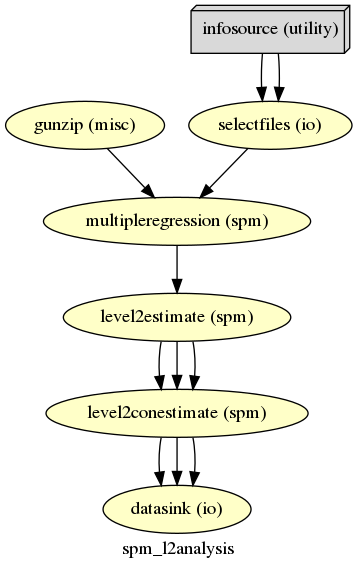

In [9]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))

In [10]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 2})

190126-17:40:16,595 nipype.workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
190126-17:40:16,894 nipype.workflow INFO:
	 Running in parallel.
190126-17:40:16,906 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 11 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 2/2.
190126-17:40:17,70 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/data/EFAT/EFAT_output/PT/workingdir/spm_l2analysis/_contrast_id_con_0010_fwhm_id_8/selectfiles".
190126-17:40:17,73 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/data/EFAT/EFAT_output/PT/workingdir/spm_l2analysis/_contrast_id_con_0009_fwhm_id_8/selectfiles".
190126-17:40:17,92 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")190126-17:40:17,92 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

190126-17:40:17,784 nipype.workflow INFO:
	 [Node] Finished 

In [11]:
from nilearn.plotting import (plot_stat_map, plot_img)
%matplotlib inline
anatimg = '/home/soyeon/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

/home/soyeon/.local/lib/python3.6/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


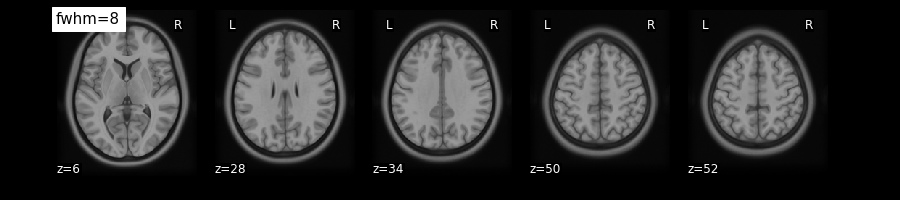

In [16]:
plot_stat_map(
    '/data/EFAT/EFAT_output/PT/datasink/2ndLevel/spm_con_0007_fwhm8/con_0001.nii', title='fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='z', cut_coords=(52, 50, 28, 6, 34), cmap='viridis');

/home/soyeon/.local/lib/python3.6/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


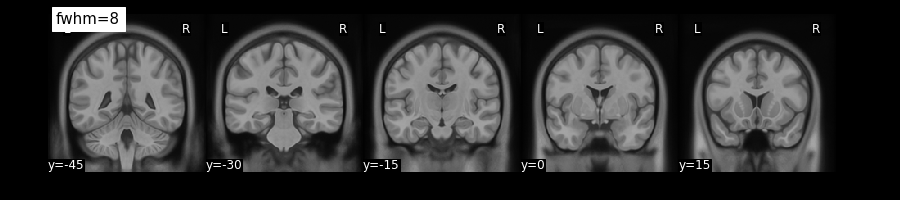

In [19]:
plot_stat_map(
    '/data/EFAT/EFAT_output/PT/datasink/2ndLevel/spm_con_0007_fwhm8/con_0002.nii', title='fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

/home/soyeon/.local/lib/python3.6/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


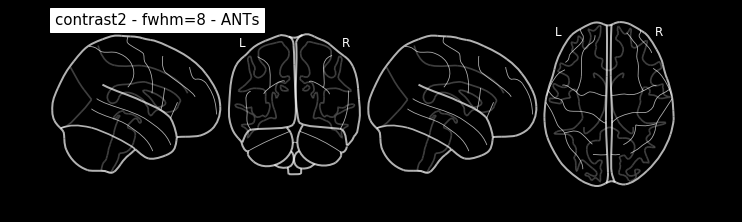

In [18]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/data/EFAT/EFAT_output/PT/datasink/2ndLevel/spm_con_0007_fwhm8/con_0001.nii', colorbar=True,
    threshold=1, display_mode='lyrz', black_bg=True, vmax=6, title='contrast2 - fwhm=8 - ANTs')